<a href="https://colab.research.google.com/github/yebiny/SkillTreePython-DeepLearning/blob/main/02.%EC%BC%80%EB%9D%BC%EC%8A%A4_%EC%B0%BD%EC%8B%9C%EC%9E%90%EC%97%90%EA%B2%8C_%EB%B0%B0%EC%9A%B0%EB%8A%94_%EB%94%A5%EB%9F%AC%EB%8B%9D/%ED%95%B4%EC%84%A4/5_4_visualizing_what_convnets_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 세팅
---

```
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning
```

In [1]:
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning

Cloning into 'SkillTreePython-DeepLearning'...
remote: Enumerating objects: 646, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 646 (delta 134), reused 189 (delta 124), pack-reused 427
Receiving objects: 100% (646/646), 30.66 MiB | 21.09 MiB/s, done.
Resolving deltas: 100% (327/327), done.


```
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/02.케라스_창시자에게_배우는_딥러닝/scripts')
from import_lib import *
```

In [2]:
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/02.케라스_창시자에게_배우는_딥러닝/scripts')
from import_lib import *

# 컨브넷의 학습 시각화하기

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%94%A5%EB%9F%AC%EB%8B%9D/) 책의 5장 4절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다.

----

딥러닝 모델을 '블랙 박스' 같다고 자주 이야기합니다. 학습된 표현에서 사람이 이해하기 쉬운 형태를 뽑아내거나 제시하기 어렵기 때문입니다. 일부 딥러닝 모델에서는 이 말이 어느정도 맞지만 컨브넷에서는 전혀 아닙니다. 컨브넷의 표현은 시각적인 개념을 학습한 것이기 때문에 시각화하기 아주 좋습니다. 2013년부터 이런 표현들을 시각화하고 해석하는 다양한 기법들이 개발되었습니다. 여기서 모두를 다룰 수는 없지만 가장 사용이 편하고 유용한 세 가지 기법을 다루겠습니다.

* 컨브넷 중간 층의 출력(중간 층에 있는 활성화)을 시각화하기 : 연속된 컨브넷층이 입력을 어떻게 변형시키는지 이해하고 개별적인 컨브넷 필터의 의미를 파악하는 데 도움이 됩니다.
* 컨브넷 필터를 시각화하기 : 컨브넷의 필터가 찾으려는 시각적인 패턴과 개념이 무엇인지 상세하게 이해하는 데 도움이 됩니다.
* 클래스 활성화에 대한 히트맵을 이미지에 시각화하기 : 이미지의 어느 부분이 주어진 클래스에 속하는 데 기여했는지 이해하고 이미지에서 객체의 위치를 추정하는 데 도움이 됩니다.

첫 번째 방법인 활성화 출력을 시각화하는 기법을 위해서 5.2절에 있는 강아지 vs. 고양이 분류 문제에서 처음부터 훈련시킨 작은 컨브넷을 사용하겠습니다. 다른 두 가지 방법을 위해서는 5.3절에 소개된 VGG16 모델을 사용하겠습니다.

## 클래스 활성화의 히트맵 시각화하기

한 가지 시각화 기법을 더 소개하겠습니다. 이 방법은 이미지의 어느 부분이 컨브넷의 최종 분류 결정에 기여하는지 이해하는 데 유용합니다. 분류에 실수가 있는 경우 컨브넷의 결정 과정을 디버깅하는 데 도움이 됩니다. 또한 이미지에 특정 물체가 있는 위치를 파악하는 데 사용할 수도 있습니다.

이 기법의 종류를 일반적으로 클래스 활성화 맵(CAM) 시각화라고 부릅니다. 입력 이미지에 대한 클래스 활성화의 히트맵을 만듭니다. 클래스 활성화 히트맵은 특정 출력 클래스에 대해 입력 이미지의 모든 위치에 대해 계산된 2D 점수 그리드입니다. 클래스에 대해 각 위치가 얼마나 중요한지를 알려 줍니다. 예를 들어 강아지 vs. 고양이 컨브넷에 한 이미지를 주입하면 CAM 시각화는 고양이 클래스에 대한 히트맵을 생성하여 이미지에서 고양이와 비슷한 부분을 알려 줍니다. 강아지 클래스에 대한 히트맵은 이미지에서 강아지와 같은 부분을 알려 줍니다.

여기서 사용할 구체적인 구현은 [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)에 기술되어 있는 것입니다. 이 방법은 매우 간단합니다. 입력 이미지가 주어지면 합성곱 층에 있는 특성 맵의 출력을 추출합니다. 그 다음 특성 맵의 모든 채널의 출력에 채널에 대한 클래스의 그래디언트 평균을 곱합니다. 이 기법을 직관적으로 이해하는 방법은 다음과 같습니다. '입력 이미지가 각 채널을 활성화하는 정도'에 대한 공간적인 맵을 '클래스에 대한 각 채널의 중요도'로 가중치를 부여하여 '입력 이미지가 클래스를 활성화하는 정도'에 대한 공간적인 맵을 만드는 것입니다.

사전 훈련된 VGG16 네트워크를 다시 사용하여 이 기법을 시연해 보겠습니다:

In [12]:
vgg = applications.VGG16(weights='imagenet')
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

초원을 걷는 어미와 새끼 아프리카 코끼리의 이미지(크리에이티브 커먼즈(Creative Commons) 라이선스)를 적용해 보겠습니다:


![elephants](https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg)

이 이미지를 VGG16 모델이 인식할 수 있도록 변환해보죠. 이 모델은 224 × 224 크기의 이미지에서 훈련되었고 `keras.applications.vgg16.preprocess_input` 함수에 있는 몇 가지 규칙에 따라 전처리 되었습니다. 그러므로 이 이미지를 로드해서 224 × 224 크기로 변경하고 넘파이 float32 텐서로 바꾼 다음 이 전처리 함수를 적용해야 합니다.

In [13]:
img_path = '/content/SkillTreePython-DeepLearning/dataset/gradcam_imgs/elephant.jpg'
#plt.plot 삭제

In [14]:
# tf.keras.preprocessing 이용한 이미지 처리
img = preprocessing.image.load_img(img_path, target_size=(224,224)) # vgg 인풋 크기에 맞추기
img = preprocessing.image.img_to_array(img) # 배열(넘파이 , 텐서 )로 변환
img = np.expand_dims(img, axis=0) # 입력 모양 변환 (개수, W, H, C)
x = applications.vgg16.preprocess_input(img) # 나머지 vgg에 적합한 전처리 과정
x.shape 

(1, 224, 224, 3)

In [15]:
preds = vgg.predict(x) # (1개 샘플에 대한 , 1000개 클래스 각각에 대한 확률)
argidx = np.argmax(preds, axis=1)[0]
top_preds = applications.imagenet_utils.decode_predictions(preds, top=3)
print(preds.shape, argidx, top_preds)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(1, 1000) 386 [[('n02504458', 'African_elephant', 0.90942055), ('n01871265', 'tusker', 0.086183496), ('n02504013', 'Indian_elephant', 0.0043545887)]]


이 이미지에 대한 상위 세 개의 예측 클래스는 다음과 같습니다.

* 아프리카 코끼리 (92.5% 확률)
* 코끼리(tusker) (7% 확률)
* 인도 코끼리 (0.4% 확률)

네트워크는 이 이미지가 아프리카 코끼리를 담고 있다고 인식했습니다. 예측 벡터에서 최대로 활성화된 항목은 '아프리카 코끼리' 클래스에 대한 것으로 386번 인덱스입니다:

이미지에서 가장 아프리카 코끼리 같은 부위를 시각화하기 위해 Grad-CAM 처리 과정을 구현하겠습니다:

In [45]:
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()

vgg_output = vgg.output[:, argidx] # 1
print('vgg 최종 출력(정답) 함수: ', vgg_output.shape)
last_cnn_output = vgg.get_layer('block5_conv3').output # 2
print('마지막 컨볼루션 레이어 출력 함수: ', last_cnn_output.shape)
grads  = K.gradients(vgg_output, last_cnn_output )[0] # 1을 2로 미분한 값 구하기
print(grads) # (개수, 14, 14, 512)
pooled_grads = K.mean(grads, axis=(0,1,2) ) # 채널 512개, 채널별로 평균 -> (512)

# 여기까지 일종의 함수 나열 -> 함수
cam_iter = K.function([vgg.input] , [pooled_grads, last_cnn_output[0]])

vgg 최종 출력(정답) 함수:  (None,)
마지막 컨볼루션 레이어 출력 함수:  (None, 14, 14, 512)
Tensor("gradients_2/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)


In [46]:
# (512), (14,14,512)
poled_grads_value, conv_layer_output_value = cam_iter([x])
for i in range(512):
  conv_layer_output_value[:,:,i] *=poled_grads_value[i]
# 채널별로 평균
heatmap = np.mean(conv_layer_output_value, axis=-1)

시각화를 위해 히트맵을 0과 1 사이로 정규화하겠습니다. 최종 결과는 그림 5-35와 같습니다:

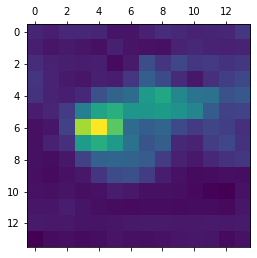

In [47]:
# 0-1 정규화 : 최대값을 나눠주면 된다.
heatmap = heatmap/np.max(heatmap)
plt.matshow(heatmap)

In [48]:

# 음수들은 0으로 바꾸기
heatmap = np.maximum(heatmap,0)

마지막으로 OpenCV를 사용해 앞에서 얻은 히트맵에 원본 이미지를 겹친 이미지를 만들겠습니다:

(600, 899, 3)
(600, 899)
(600, 899, 3)


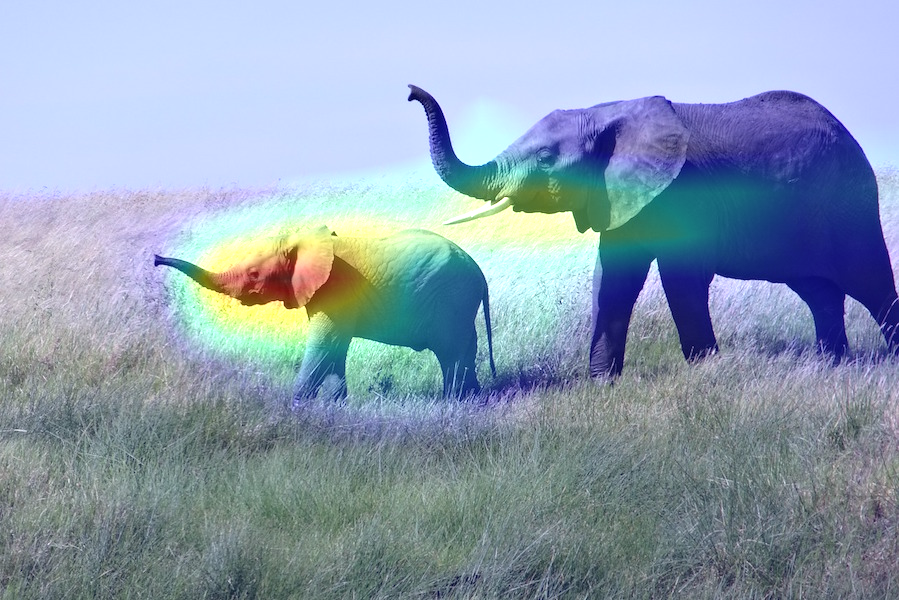

In [49]:
from google.colab.patches import cv2_imshow

img = cv2.imread(img_path) # (H, W)
print(img.shape)
heatmap_resize = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # W, H # resolution 변환
print(heatmap_resize.shape)
heatmap_uint = np.uint8(255*heatmap_resize) # 정수 변환
heatmap_color = cv2.applyColorMap(heatmap_uint, cv2.COLORMAP_JET) # 1->3 channel 
print(heatmap_color.shape)
img_with_heatmap = img + heatmap_color*0.4
cv2_imshow(img_with_heatmap)

이 시각화 기법은 두 개의 중요한 질문에 대한 답을 줍니다:

* 왜 네트워크가 이 이미지에 아프리카 코끼리가 있다고 생각하는가?
* 아프리카 코끼리가 사진 어디에 있는가?

특히 코끼리 새끼의 귀가 강하게 활성화된 점이 흥미롭습니다. 아마도 이것은 네트워크가 아프리카 코끼리와 인도 코끼리의 차이를 구분하는 방법일 것입니다.